Create simulation data

In [476]:
import numpy as np
from sklearn.model_selection import train_test_split

# Generate initial data
## Model: y = weight*x + bias 

weight = 10
bias = 3.0

np.random.seed(0)
X = np.random.random_sample(100)
y = weight * X + bias

## Spliting data for traning and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

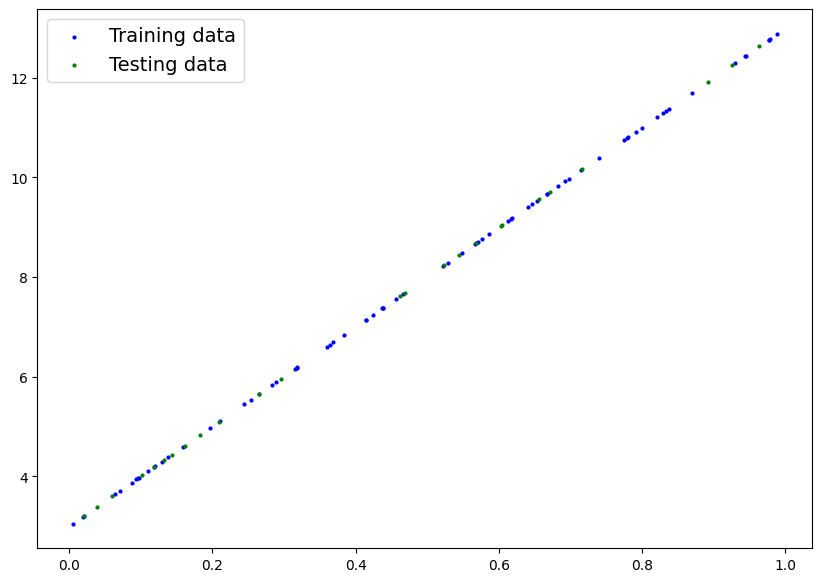

In [477]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();

Create linear model

In [478]:
# Check cuda
!nvidia-smi

Wed Nov 19 21:14:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   53C    P2              42W / 170W |    133MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [479]:
# Install pytorch: https://pytorch.org/get-started/locally/#linux-pip
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126 

In [483]:
import torch
from torch import nn 

# Setup device-agnostic
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define the model
torch.manual_seed(42)
class Linear_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.parameter.Parameter(torch.rand(1))
        self.bias = nn.parameter.Parameter(torch.rand(1))

    def forward(self, x):
        return self.weight * x + self.bias

# Create model
model_0 = Linear_model().to(device)
model_0.state_dict()

# Create tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device).unsqueeze(dim=1)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(dim=1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32, device=device).unsqueeze(dim=1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32, device=device).unsqueeze(dim=1)

## Select loss function and optimizer
loss_fnc = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

## Run training loop
epochs = 100


# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ## Training
    # Put model in training mode (this is default state)
    model_0.train()

    # 1. Forward pass on train data
    y_pred = model_0.forward(X_train_t)

    # 2. Calculae loss by function (how different to true output)
    loss = loss_fnc(y_pred, y_train_t)

    # 3. Zero grad the optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Progress optimizer
    optimizer.step()

    ## Testing
    # Put model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward the test data
        test_pred = model_0.forward(X_test_t)

        # 2. Calculate loss on test data
        test_loss = loss_fnc(test_pred, y_test_t)

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.to("cpu").detach().numpy())
            test_loss_values.append(test_loss.to("cpu").detach().numpy())
            print(f"Epoch: {epoch} | MAE train loss: {loss} | MAE test loss: {test_loss}")

Using cuda device
Epoch: 0 | MAE train loss: 6.577189922332764 | MAE test loss: 5.850439548492432
Epoch: 10 | MAE train loss: 6.564762592315674 | MAE test loss: 5.838403701782227
Epoch: 20 | MAE train loss: 6.552335739135742 | MAE test loss: 5.82636833190918
Epoch: 30 | MAE train loss: 6.539907932281494 | MAE test loss: 5.814333438873291
Epoch: 40 | MAE train loss: 6.5274810791015625 | MAE test loss: 5.802298069000244
Epoch: 50 | MAE train loss: 6.5150532722473145 | MAE test loss: 5.790262222290039
Epoch: 60 | MAE train loss: 6.502626419067383 | MAE test loss: 5.77822732925415
Epoch: 70 | MAE train loss: 6.490198612213135 | MAE test loss: 5.766192436218262
Epoch: 80 | MAE train loss: 6.477771282196045 | MAE test loss: 5.754157066345215
Epoch: 90 | MAE train loss: 6.465343475341797 | MAE test loss: 5.74212121963501


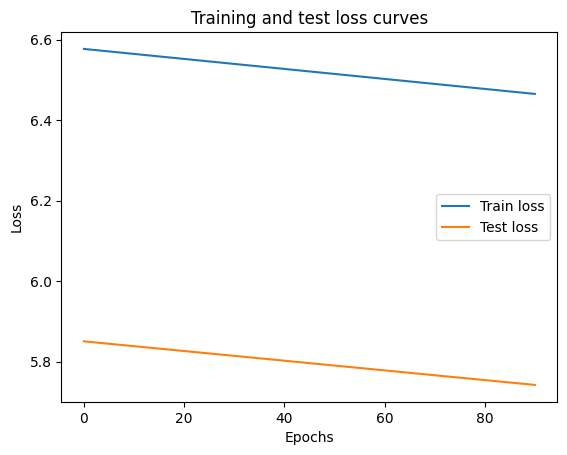

In [484]:
## Visualization
import matplotlib.pyplot as plt

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [485]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.9315], device='cuda:0')), ('bias', tensor([1.0150], device='cuda:0'))])

And the original values for weights and bias are:
weights: 10, bias: 3.0
